<a href="https://colab.research.google.com/github/fofojaramillo/birds-app/blob/main/reescaling_birds_model_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
#---------------------------------------
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, BackupAndRestore
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Rescaling
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import load_model
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_folder = '/content/data'
if not os.path.exists(data_folder):
  !pip install kaggle
  from google.colab import drive
  drive.mount('/content/drive')
  !mkdir ~/.kaggle
  !cp '/content/drive/MyDrive/Colab Notebooks/kaggle-API-credential/kaggle.json' ~/.kaggle/kaggle.json
  !chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d gpiosenka/100-bird-species
  !mkdir /content/data
  !unzip /content/100-bird-species.zip -d /content/data/bird-dataset
  !rm /content/100-bird-species.zip
else:
  print("La carpeta 'data' ya existe, se omiten los comandos de descarga y descompresión.")

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/120.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/121.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/122.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/123.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/124.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/125.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/126.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/127.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/128.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/129.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/130.jpg  
  inflating: /content/data/bird-dataset/train/WHITE TAILED TROPIC/131.jpg  
  inflating: /content

In [ ]:
image_gen = ImageDataGenerator()
train_dataset = image_gen.flow_from_directory(
 "/content/data/bird-dataset/train",
    target_size=(224, 224),
    batch_size=32)
test_dataset = image_gen.flow_from_directory(
   "/content/data/bird-dataset/test",
    target_size=(224, 224),
    batch_size=32,
    shuffle = False)
validata = image_gen.flow_from_directory(
   "/content/data/bird-dataset/valid",
    target_size=(224, 224),
    batch_size=32,
    shuffle = False)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.


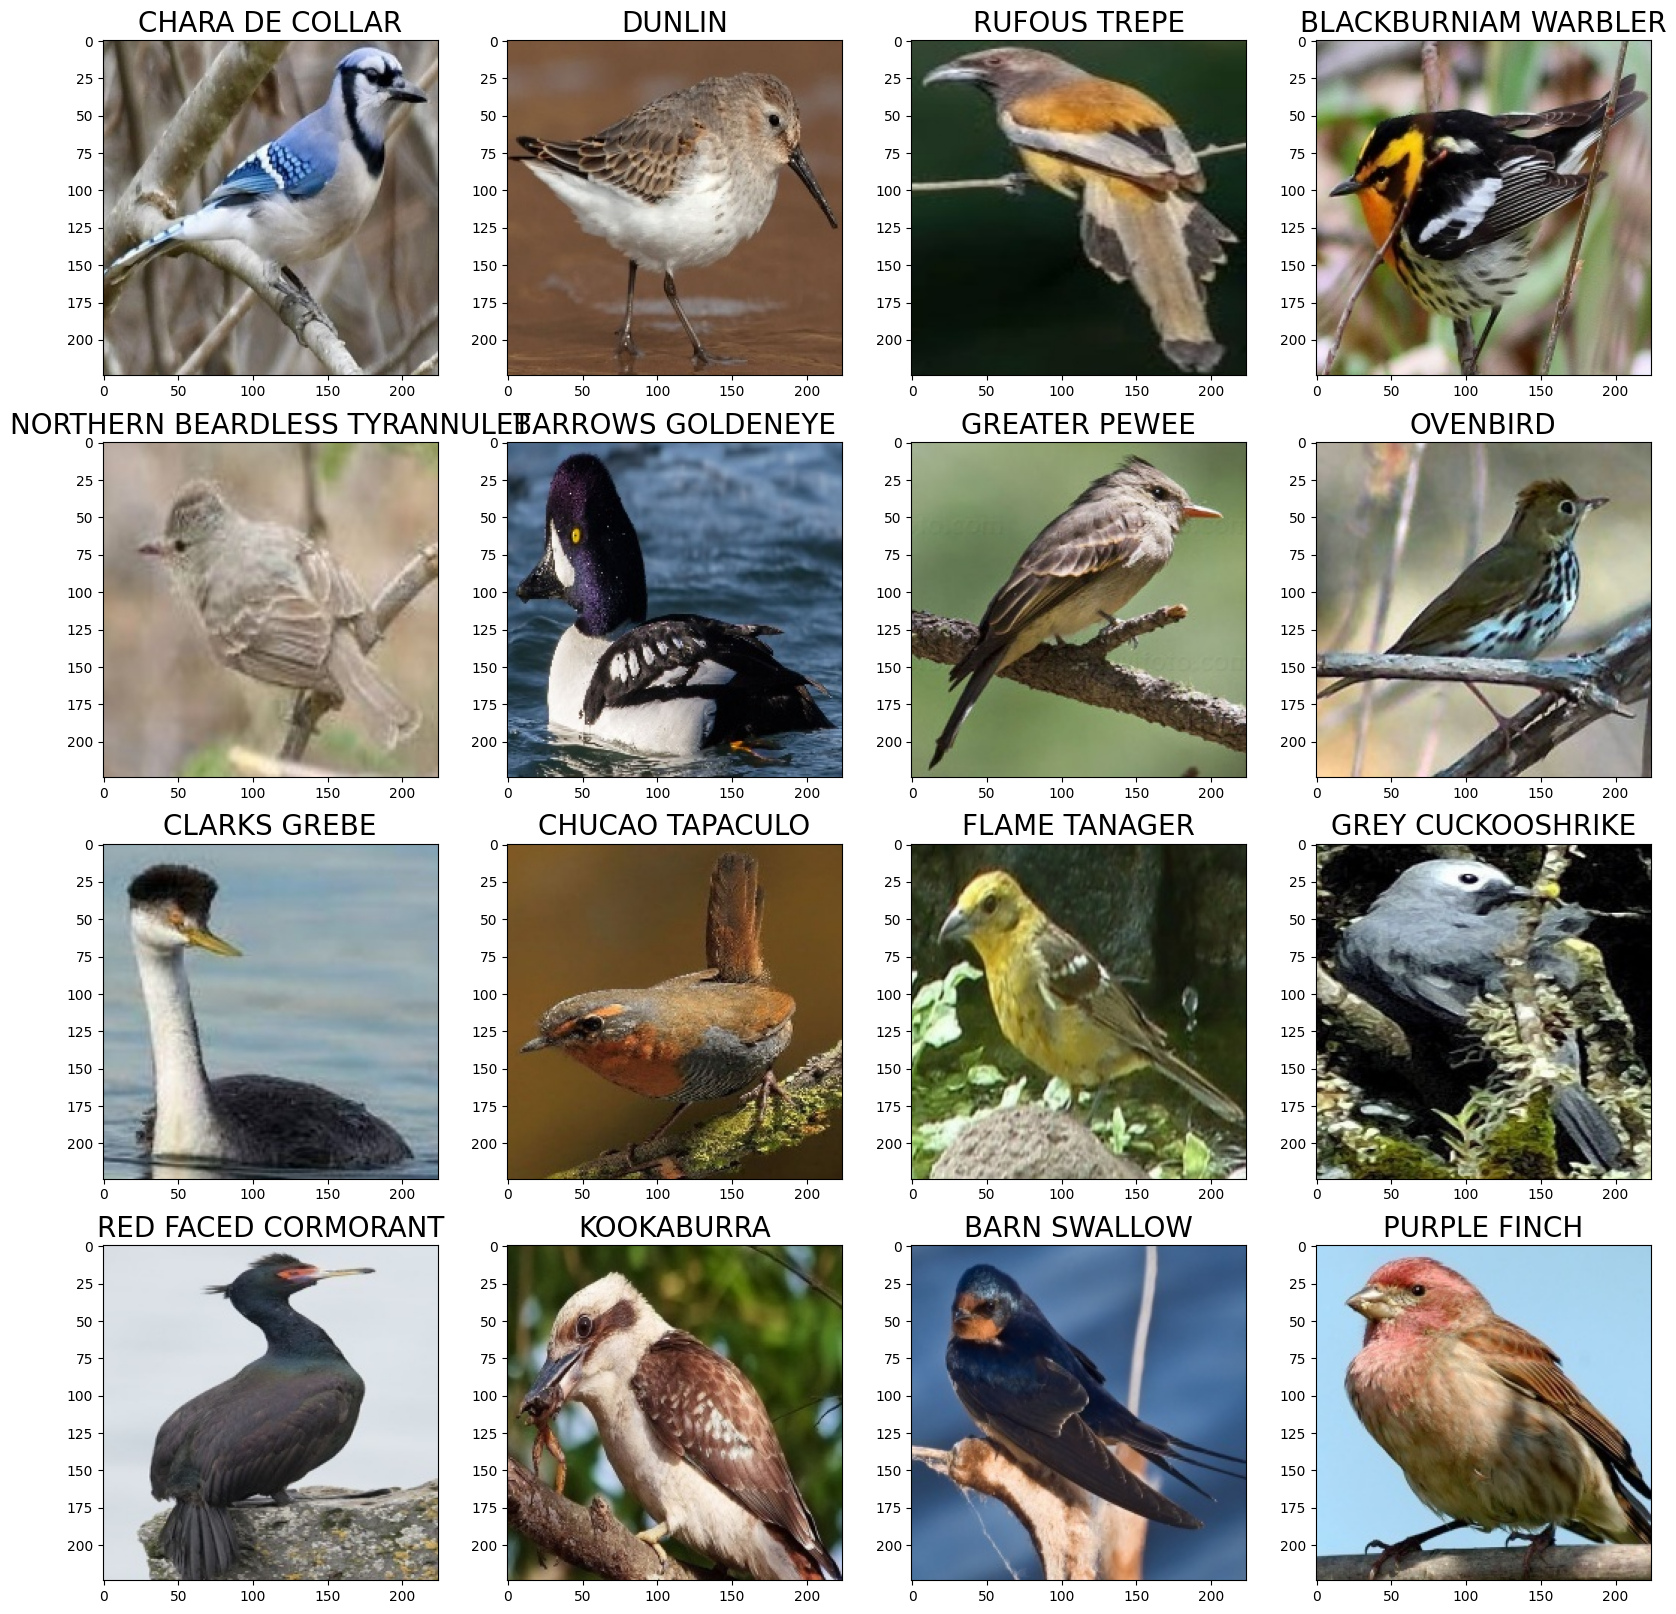

In [ ]:
class_dict = train_dataset.class_indices
classes = list(class_dict.keys())
images, labels = next(train_dataset)

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color='k', fontsize=20)
plt.show()

In [ ]:
num_classes = len(classes)
num_classes

525

Modelo pre-entreado

###Modelo

usando transferencia de aprendizaje

In [35]:
image_size = (224,224)+(3,)

In [ ]:
import keras

In [37]:
base_model = keras.applications.EfficientNetV2B3(
    input_shape = image_size, # [96, 128, 160, 192, 224] No acepta imagenes mas grandes
    include_top = False,
    weights     = 'imagenet',
    include_preprocessing = False
)

base_model.trainable = False

model_tl = Sequential([
    tf.keras.Input(shape=image_size),
    Rescaling(1./255, input_shape=image_size),
    base_model,
    keras.layers.GlobalMaxPooling2D(name = 'max_pooling'),
    keras.layers.BatchNormalization(name = 'batch_norm'),
    Dense(1000, activation = 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_tl.build(input_shape=(None, *image_size))

model_tl.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b3 (Functio  (None, 7, 7, 1536)        12930622  
 nal)                                                            
                                                                 
 max_pooling (GlobalMaxPool  (None, 1536)              0         
 ing2D)                                                          
                                                                 
 batch_norm (BatchNormaliza  (None, 1536)              6144      
 tion)                                                           
                                                                 
 dense_11 (Dense)            (None, 1000)              1537000   
                                                      

In [38]:
model_tl.compile(optimizer=Adamax(learning_rate=0.001),
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])


In [39]:
es = EarlyStopping(monitor='val_loss', mode='min',patience=3)
checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/Colab Notebooks/model-backup",
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only=True
)

In [40]:
historial = model_tl.fit(
                      train_dataset,
                      epochs = 25,
                      validation_data = validata,
                      callbacks=[checkpoint, es],
                      verbose = 1
                      )

Epoch 1/25
2645/2645 [==============================] - 188s 67ms/step - loss: 2.0085 - accuracy: 0.5490 - val_loss: 0.4792 - val_accuracy: 0.8709
Epoch 2/25
2645/2645 [==============================] - 170s 64ms/step - loss: 0.9794 - accuracy: 0.7483 - val_loss: 0.3599 - val_accuracy: 0.9040
Epoch 3/25
2645/2645 [==============================] - 175s 66ms/step - loss: 0.7523 - accuracy: 0.8013 - val_loss: 0.3015 - val_accuracy: 0.9223
Epoch 4/25
2645/2645 [==============================] - 174s 66ms/step - loss: 0.6308 - accuracy: 0.8298 - val_loss: 0.2742 - val_accuracy: 0.9238
Epoch 5/25
2645/2645 [==============================] - 178s 67ms/step - loss: 0.5517 - accuracy: 0.8493 - val_loss: 0.2506 - val_accuracy: 0.9322
Epoch 6/25
2645/2645 [==============================] - 128s 48ms/step - loss: 0.4931 - accuracy: 0.8635 - val_loss: 0.2499 - val_accuracy: 0.9318
Epoch 7/25
2645/2645 [==============================] - 178s 67ms/step - loss: 0.4436 - accuracy: 0.8757 - val_loss: 0

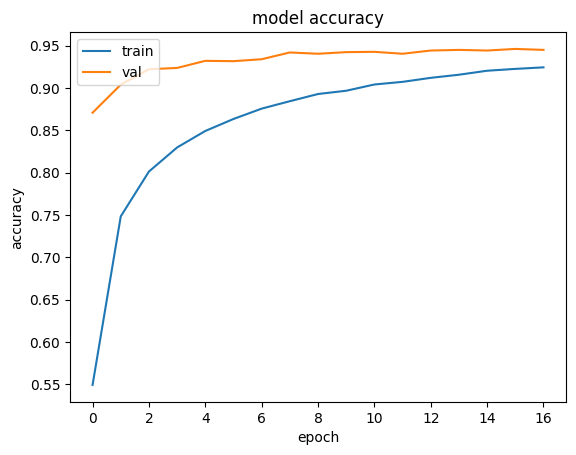

In [41]:
plt.plot(historial.history['accuracy'])
plt.plot(historial.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

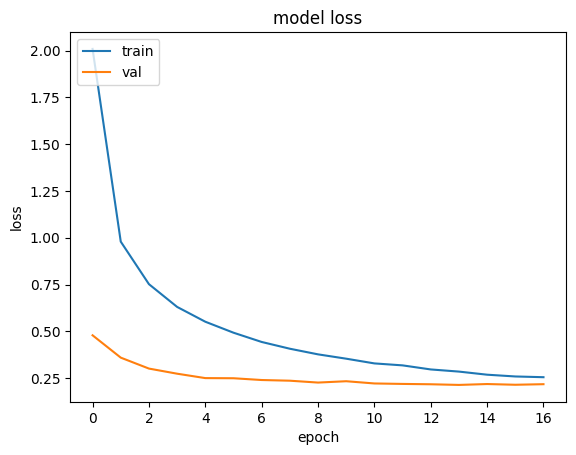

In [42]:
plt.plot(historial.history['loss'])
plt.plot(historial.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [43]:
y_prob = model_tl.predict(test_dataset)
y_pred = np.argmax(y_prob, axis=1)

83/83 [==============================] - 10s 42ms/step


In [44]:
y_true = []

test_labels = []

for i in range(len(test_dataset)):
    test_labels.extend(test_dataset[i][1])

y_true = np.argmax(test_labels, axis=1)

accuracy_score(y_true, y_pred)

0.9660952380952381

In [47]:
if not os.path.exists('/content/drive/MyDrive/Colab Notebooks/Modelos'):
  !mkdir '/content/drive/MyDrive/Colab Notebooks/Modelos'
model_tl.save('/content/drive/MyDrive/Colab Notebooks/Modelos/modelo_birds.h5')